# EMA trading OO version

In [1]:
import os
import sys
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

import ipywidgets as widgets
from ipywidgets import TwoByTwoLayout
from ipywidgets import HBox, VBox, Label
from ipywidgets import interactive_output, jslink
from ipywidgets import FloatSlider, IntSlider, SelectionSlider, SelectionRangeSlider
from ipywidgets import FloatText, IntText, Dropdown
from IPython.display import display, clear_output

import trading as tra
import trading_plots as trp
import trading_defaults as dft
import utilities as util
import topo_map as tpm
import ticker as tkr

%matplotlib inline
%load_ext autoreload
%autoreload 2
%load_ext snakeviz

### Default parameters

In [2]:
color_schemes = dft.SURFACE_COLOR_SCHEMES
N_MAXIMA_SAVE = 20 # number of maxima to save to file

START_DATE = '2017-07-15'
TODAY     = dft.TODAY

In [3]:
END_DATE = TODAY
#END_DATE = '2021-04-06'

TICKER     = 'ETH-USD'
REFRESH    = True # Download fresh Yahoo data 
print(START_DATE, 'to',END_DATE)

2017-07-15 to 2021-04-11


### Data download

In [4]:
try:
    ticker_obj = tra.load_security_oo(dirname = dft.DATA_DIR, 
                                      ticker  = TICKER,
                                      refresh = REFRESH,
                                      period  = dft.DEFAULT_PERIOD,
                                     )
except IndexError:
        print(f'Could not load {TICKER}')
except:
    print(f'Error type {sys.exc_info()[0]}')
else:
    security = pd.DataFrame(ticker_obj.get_market_data()[f'Close_{TICKER}'])
    security.rename(columns={f'Close_{TICKER}': "Close"},
                    inplace=True)
security

Loading ticker ETH-USD
[*********************100%***********************]  1 of 1 completed

Ethereum USD data loaded


,Close
Date,
2016-04-11,8.6437902
2016-04-12,7.4423099
2016-04-13,8.0444202
2016-04-14,8.3872404
2016-04-15,8.2427797
...,...
2021-04-07,1971.0772705
2021-04-08,2088.5737305
2021-04-09,2072.1088867


In [5]:
# Set date range
date_range = util.get_datetime_date_range(security, START_DATE, END_DATE)
print(date_range)

[datetime.datetime(2017, 7, 15, 0, 0), datetime.datetime(2021, 4, 11, 0, 0)]


In [6]:
ticker_obj.get_currency_symbol()

'$'

#### Setup default start & end dates

In [7]:
def save_figure(plot_dir, prefix, dpi=360, extension='png'):
    '''
    Saves figure to file
    variables:
        plot_dir - directory to plot to
        prefix   - filename without its extension
    '''
    filename = f'{prefix}.{extension}'
    pathname = os.path.join(plot_dir, filename)
    print(f'Saving to {pathname}')
    try:
        plt.savefig(pathname,
                    dpi = dpi,
                    transparent = False,
                    facecolor='white',
                    edgecolor='none',
                    orientation = 'landscape',
                    bbox_inches = 'tight'
                    )
    except TypeError as ex:
        print(f'Could not save to {pathname}: {ex}')
    except:
        print(f'Error type {sys.exc_info()[0]}')
    else:
        pass

In [8]:
topomap = tpm.Topomap(TICKER, date_range)
if os.path.exists(topomap.get_ema_map_filename()):
    print(f'Reading EMA map from {topomap.get_ema_map_filename()}')
    topomap.read_ema_map()
else: # If not saved, compute itß
    print('Building EMA map')
    topomap.build_ema_map(security, date_range,)
topomap.build_best_emas(N_MAXIMA_SAVE)
best_span, best_buffer, best_ema, hold = topomap.get_global_max()

Reading EMA map from data/ETH-USD/ETH-USD_2017-07-15_2021-04-11_ema_map.csv


## Plotting functions

In [9]:
def plot_span_range(buffer, n_best, fee_pct, date_range):
    topomap.set_date_range(date_range)
    topomap.plot_span_range(ticker_object = ticker_obj, 
                            security      = security, 
                            buffer        = buffer, 
                            n_best        = n_best, 
                            fee_pct       = fee_pct, 
                           )

In [10]:
#self, ticker_object, security, span, n_best, fee_pct, date_range, extension='png'
def plot_buffer_range(span, n_best, fee_pct, date_range):
    topomap.set_date_range(date_range)
    topomap.plot_buffer_range(ticker_object = ticker_obj, 
                              security      = security, 
                              span          = span, 
                              n_best        = n_best, 
                              fee_pct       = fee_pct, 
                             )

In [11]:
# test driver for trp.plot_span_range
%time 
plot = False
if plot:
    plot_span_range(buffer     = .01, 
                    n_best     = 12, 
                    fee_pct    = dft.FEE_PCT, 
                    date_range = date_range,
                   )

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


In [12]:
# test driver for trp.plot_buffer_range
%time 
plot = False
if plot:
    plot_buffer_range(span       = 20, 
                      n_best     = 12, 
                      fee_pct    = dft.FEE_PCT, 
                      date_range = date_range,
                    )

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 4.77 µs


In [13]:
def plot_time_series(span, display_dates, fee_pct, buffer, price_flag, ema_flag, buffer_flag, arrow_flag, stats_flag):
    save_flag = False
    flags = [price_flag, ema_flag, buffer_flag, arrow_flag, stats_flag, save_flag]

    ticker_obj.plot_time_series(display_dates = display_dates, 
                                security      = security, 
                                span          = span, 
                                buffer        = buffer, 
                                flags         = flags, 
                                fee_pct       = dft.FEE_PCT,
                               )

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 4.77 µs


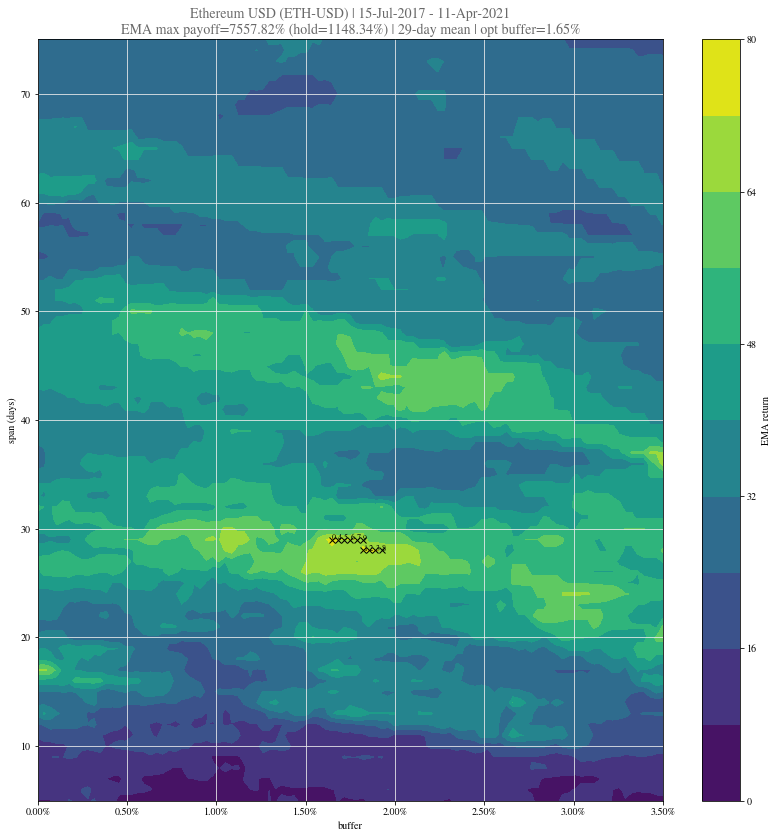

In [14]:
# Driver for plot_buffer_span_contours
plot = True
if plot:
    %time 
    #%prun -D plot_contours.prof
    topomap.contour_plot(ticker_obj, date_range)

In [15]:
def surface_plot(azimuth, elevation, rdist, colors):
    topomap.surface_plot(ticker_obj, 
                         date_range, 
                         colors, 
                         azimuth, 
                         elevation, 
                         rdist,
                        )

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs


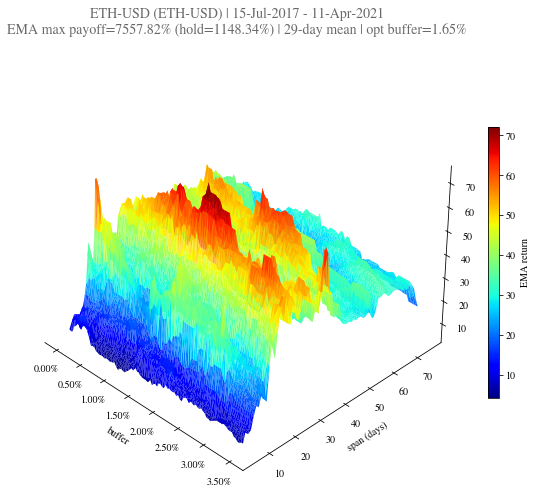

In [16]:
# Driver for surface_plot
plot = True
if plot:
    %time 
    #%prun -D plot_3D.prof
    topomap.surface_plot(ticker_obj, 
                         date_range,
                         colors=dft.SURFACE_COLOR_SCHEME,
                         azim=dft.PERSPECTIVE[0], 
                         elev=dft.PERSPECTIVE[1], 
                         rdist=dft.PERSPECTIVE[2],
                        )

### Interactive plots

#### Widget defaults

In [17]:
### Default parameter values
string_style = {'description_width': 'initial', 
                'handle_color':      'lawngreen'}

start_period, end_period = util.get_datetime_date_range(security, START_DATE, END_DATE)
dates        = pd.date_range(start_period, end_period, freq='D')
date_options = [(date.strftime(' %d/%m/%Y'), date) for date in dates]
date_index   = (0, len(date_options) - 1)

# Tx/broker's fee
min_fee     = 0.0
max_fee     = .01
delta_fee   = .0005
default_fee = dft.FEE_PCT

# of days for running mean
min_span     = dft.MIN_SPAN
max_span     = dft.MAX_SPAN
delta_span   = 1
default_span = best_span

# buffer around EMA
min_buffer     = dft.MIN_BUFF
max_buffer     = dft.MAX_BUFF
delta_buffer   = .0001
default_buffer = best_buffer

# number of maxima
max_value     = 15
default_value = 12

# 3D horizontal & vertical sliders
min_azimuth     = dft.MIN_AZIMUTH
max_azimuth     = dft.MAX_AZIMUTH
delta_azimuth   = 1
default_azimuth = dft.PERSPECTIVE[0]

min_elevation     = dft.MIN_ELEVATION
max_elevation     = dft.MAX_ELEVATION
delta_elevation   = 1
default_elevation = dft.PERSPECTIVE[1]

min_distance     = dft.MIN_DISTANCE
max_distance     = dft.MAX_DISTANCE
delta_distance   = 1
default_distance = dft.PERSPECTIVE[2]

surface_color_scheme = color_schemes[12]

In [18]:
## Widget methods
### Sliders
def get_span_slider():
    return IntSlider(min      = min_span,
                     max      = max_span,
                     step     = delta_span,
                     value    = default_span,
                     style    = string_style,
                     disabled = False,
                     continuous_update=False,
                     readout=True,
                     readout_format='d',
                     layout = {'width': '250px'},
                    )

def get_buffer_slider():
    return FloatSlider(min=min_buffer,
                        max=max_buffer,
                        step=delta_buffer,
                        value=default_buffer,
                        style=string_style,
                        continuous_update=False,
                        disabled=False,
                        readout=True,
                        readout_format='.2%',
                        layout      = {'width': '250px'},
                       )
    
def get_fee_slider():
    return FloatSlider(min=min_fee,
                       max=max_fee,
                       step=delta_fee,
                       value=default_fee,
                       style=string_style,
                       disabled=False,
                       continuous_update=False,
                       readout=True,
                       readout_format='.2%',
                       layout      = {'width': '250px'},
                      )

def get_max_values_slider():
    return SelectionSlider(options=[x for x in range(0, max_value+1)],
                          value=default_value,
                          description='Number of maxima:',
                          style=string_style,
                          disabled=False,
                          continuous_update=False,
                          readout=True,
                          readout_format='d',
                          layout      = {'width': '500px'},
                          )
                       
def get_date_range_slider():
    return SelectionRangeSlider(options  = date_options,
                                 index   = date_index,
                                 description = 'Period:',
                                 orientation = 'horizontal',
                                 style       = string_style,
                                 layout      = {'width': '500px'}
                                )

def get_azimuth_slider():
    return IntSlider(min      = min_azimuth,
                     max      = max_azimuth,
                     step     = delta_azimuth,
                     value    = default_azimuth,
                     style    = string_style,
                     disabled = False,
                     continuous_update=False,
                     readout=True,
                     readout_format='d',
                     layout = {'width': '250px'},
                    )

def get_elevation_slider():
    return IntSlider(min      = min_elevation,
                     max      = max_elevation,
                     step     = delta_elevation,
                     value    = default_elevation,
                     style    = string_style,
                     disabled = False,
                     orientation='vertical',
                     continuous_update=False,
                     readout=True,
                     readout_format='d',
                     layout = {'height': '100px', 'width': '50px'},
                    )

def get_distance_slider():
    return IntSlider(min      = min_distance,
                     max      = max_distance,
                     step     = delta_distance,
                     value    = default_distance,
                     style    = string_style,
                     disabled = False,
                     continuous_update=False,
                     readout=True,
                     readout_format='d',
                     layout = {'width': '250px'},
                    )

### Text boxes
def get_fee_text_box():
    return FloatText(min=min_fee,
                     max=max_fee,
                     step=delta_fee,
                     value=default_fee,
                     description='Fees:',
                     style=string_style,
                     disabled=False,
                     readout_format='6.3%',
                     layout={'width': '150px'},
                    )
                       
def get_span_text_box():
    return IntText(min   = min_span,
                   max   = max_span,
                   step  = delta_span,
                   value = default_span,
                   style          = string_style,
                   disabled       = False,
                   description    = 'Span:',
                   readout_format = 'd',
                   layout={'width': '150px'},
                   )
                       
def get_buffer_text_box():
    return FloatText(min   = min_fee,
                     max   = max_fee,
                     step  = delta_fee,
                     value = default_fee,
                     style       = string_style,
                     disabled    = False,
                     description = 'Buffer:',
                     readout_format = '3%',
                     layout = {'width': '150px'},
                    )
def get_azimuth_text_box():
    return IntText(min   = min_azimuth,
                   max   = max_azimuth,
                   step  = delta_azimuth,
                   value = default_azimuth,
                   style          = string_style,
                   disabled       = False,
                   description    = 'Azimuth:',
                   readout_format = 'd',
                   layout={'width': '150px'},
                   )

def get_elevation_text_box():
    return IntText(min   = min_elevation,
                   max   = max_elevation,
                   step  = delta_elevation,
                   value = default_elevation,
                   style          = string_style,
                   disabled       = False,
                   description    = 'Elevation:',
                   readout_format = 'd',
                   layout={'width': '150px'},
                   )

def get_distance_text_box():
    return IntText(min   = min_distance,
                   max   = max_distance,
                   step  = delta_distance,
                   value = default_distance,
                   style          = string_style,
                   disabled       = False,
                   description    = 'Distance:',
                   readout_format = 'd',
                   layout={'width': '150px'},
                   )

# Dropdowns
def get_color_dropwdown():
    return Dropdown(options     = color_schemes,
                    value       = surface_color_scheme,
                    description = 'Color scheme:',
                    style       = string_style,
                    disabled    = False,
                    layout={'width': '250px'},
                    )

# Checkboxes
checkbox_width = '150px'
def get_ema_checkbox():
    return widgets.Checkbox(
        value       = True,
        description = 'EMA',
        disabled    = False,
        indent      = False,
        layout={'width': checkbox_width},
        tooltip = 'Display EMA',
    )

def get_buffer_checkbox():
    return widgets.Checkbox(
        value       = False,
        description = 'Buffer',
        disabled    = False,
        indent      = False,
        layout={'width': checkbox_width},
        tooltip = 'Display buffer',
    )

def get_price_checkbox():
    return widgets.Checkbox(
        value       = True,
        description = 'Price',
        disabled    = False,
        indent      = False,
        layout={'width': checkbox_width},
        tooltip = 'Display market prices',
    )

def get_arrow_checkbox():
    return widgets.Checkbox(
        value       = True,
        description = 'Buy/sell',
        disabled    = False,
        indent      = False,
        layout={'width': checkbox_width},
        tooltip = 'Display buy/sell arrows',
    )

def get_stats_checkbox():
    return widgets.Checkbox(
        value       = True,
        description = 'Display stats',
        disabled    = False,
        indent      = False,
        layout={'width': checkbox_width},
        tooltip = 'Display data statistics',
    )

# Buttons
def get_save_figure_button():
    return widgets.Button(
        #description='Save',
        value = False,
        disabled=True,
        button_style='', # 'success', 'info', 'warning', 'danger' or ''
        layout={'width': '35px'},
        tooltip = 'Save to png file',
        icon='save'
    )

#### Interactive returns for window span

In [19]:
# Mean window span range interactive optimizer
buffer_slider   = get_buffer_slider()
buffer_text_box = get_buffer_text_box()
buffer_link     = jslink((buffer_slider, 'value'), (buffer_text_box, 'value'))

max_values_slider   = get_max_values_slider()

fee_slider   = get_fee_slider()
fee_text_box = get_fee_text_box()
fee_link     = jslink((fee_slider, 'value'), (fee_text_box, 'value'))

date_range_slider = get_date_range_slider()

fee_widgets    = HBox([fee_text_box, fee_slider])
buffer_widgets = HBox([buffer_text_box, buffer_slider])

out = interactive_output(plot_span_range,
                         {'buffer'    : buffer_slider,
                          'n_best'    : max_values_slider,
                          'fee_pct'   : fee_slider,
                          'date_range': date_range_slider,
                         }
                        )

ui = TwoByTwoLayout(top_left     = fee_widgets,
                    top_right    = date_range_slider,
                    bottom_left  = buffer_widgets,
                    bottom_right = max_values_slider,
                   )

display(ui, out)

TwoByTwoLayout(children=(HBox(children=(FloatText(value=0.004, description='Fees:', layout=Layout(width='150px…

Output()

#### Interactive returns for buffer size

In [20]:
# Buffer range interactive optimizer
span_slider   = get_span_slider()
span_text_box = get_span_text_box()
span_link     = jslink((span_slider, 'value'), (span_text_box, 'value'))

max_values_slider = get_max_values_slider()

fee_slider   = get_fee_slider()
fee_text_box = get_fee_text_box()
fee_link     = jslink((fee_slider, 'value'), (fee_text_box, 'value'))

date_range_slider = get_date_range_slider()

fee_widgets    = HBox([fee_text_box, fee_slider])
span_widgets = HBox([span_text_box, span_slider])

out = interactive_output(plot_buffer_range,
                         {'span'      : span_slider,
                          'n_best'    : max_values_slider,
                          'fee_pct'   : fee_slider,
                          'date_range': date_range_slider,
                          }
                         )

ui = TwoByTwoLayout(top_left     = fee_widgets,
                    top_right    = date_range_slider,
                    bottom_left  = span_widgets,
                    bottom_right = max_values_slider,
                    )

display(ui, out)

TwoByTwoLayout(children=(HBox(children=(FloatText(value=0.004, description='Fees:', layout=Layout(width='150px…

Output()

#### Interactive buffer-span

In [21]:
# Buffer-span interactive time-series plot
fee_slider   = get_fee_slider()
fee_text_box = get_fee_text_box()
fee_link     = jslink((fee_slider, 'value'), (fee_text_box, 'value'))

span_slider   = get_span_slider()
span_text_box = get_span_text_box()
span_link     = jslink((span_slider, 'value'), (span_text_box, 'value'))

buffer_slider   = get_buffer_slider()
buffer_text_box = get_buffer_text_box()
buffer_link     = jslink((buffer_slider, 'value'), (buffer_text_box, 'value'))

price_checkbox  = get_price_checkbox()
ema_checkbox    = get_ema_checkbox()
buffer_checkbox = get_buffer_checkbox()
arrow_checkbox  = get_arrow_checkbox()
stats_checkbox  = get_stats_checkbox()

save_button       = get_save_figure_button()
date_range_slider = get_date_range_slider()


out = interactive_output(plot_time_series,
                         {'span'         : span_slider,
                          'buffer'       : buffer_slider,
                          'fee_pct'      : fee_slider,
                          'display_dates': date_range_slider,
                          'price_flag'   : price_checkbox,
                          'ema_flag'     : ema_checkbox,
                          'buffer_flag'  : buffer_checkbox,
                          'arrow_flag'   : arrow_checkbox,
                          'stats_flag'   : stats_checkbox,
                          }
                         )

fee_widgets    = HBox([fee_text_box, fee_slider])
span_widgets   = HBox([span_text_box, span_slider])
buffer_widgets = HBox([buffer_text_box, buffer_slider])
checkbox_widgets = HBox([price_checkbox, 
                         ema_checkbox, 
                         buffer_checkbox, 
                         arrow_checkbox, 
                         stats_checkbox, 
                         save_button])

top_widgets = HBox([VBox([fee_widgets, span_widgets]), 
                   VBox([date_range_slider, buffer_widgets])]
                  )
bottom_widgets = HBox([HBox([]), checkbox_widgets, HBox([])])

ui = VBox([top_widgets, bottom_widgets])

display(ui, out)

Output()

#### Interactive 3D plot

In [22]:
# Buffer-span interactive plot
elevation_slider   = get_elevation_slider()
elevation_text_box = get_elevation_text_box()
elevation_link     = jslink((elevation_slider, 'value'), (elevation_text_box, 'value'))

azimuth_slider   = get_azimuth_slider()
azimuth_text_box = get_azimuth_text_box()
azimuth_link     = jslink((azimuth_slider, 'value'), (azimuth_text_box, 'value'))

distance_slider   = get_distance_slider()
distance_text_box = get_distance_text_box()
distance_link     = jslink((distance_slider, 'value'), (distance_text_box, 'value'))

color_dropdown    = get_color_dropwdown()

#date_range_slider = get_date_range_slider()

out = interactive_output(surface_plot,
                         {'azimuth'   : azimuth_slider,
                          'elevation' : elevation_slider,
                          'rdist'     : distance_slider,
                          'colors'    : color_dropdown,
                          }
                         )

azimuth_widgets   = VBox([azimuth_text_box, azimuth_slider])
elevation_widgets = VBox([elevation_text_box, elevation_slider])
distance_widgets  = VBox([distance_text_box, distance_slider])
h_widgets         = VBox([distance_widgets, azimuth_widgets])

ui = HBox([elevation_widgets, h_widgets, color_dropdown])

display(ui, out)

Output()

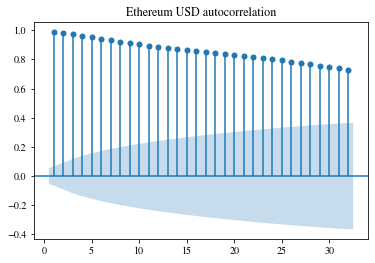

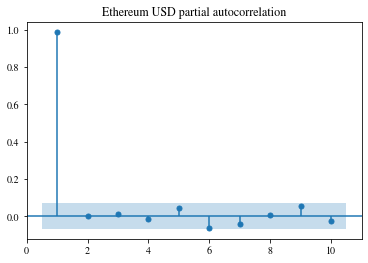

In [23]:
#Autocorrelation functions
ticker_name = ticker_obj.get_name()
series = security.loc[date_range[0]:date_range[1],'Close']
plot_acf(series, title=f'{ticker_name} autocorrelation', zero=False)
plt.show()

plot_pacf(series, lags=10, alpha=.01, title=f'{ticker_name} partial autocorrelation', zero=False)
plt.show()